In [11]:
import torch
import os
import sys
sys.path.insert(0,'../code/data_utils/SampleClass/')
from Coordinates import Coordinates
import matplotlib.pyplot as plt
plt.style.use('/home/gridsan/gschuette/universal/matplotlib/plot_style_2.txt')

Save folder for figure

In [2]:
save_folder = './normalization/'

First, show that the equations in the paper's SI are valid despite the different implementation used in the code

In [3]:
mean_dists = torch.load('../data/mean_dists.pt')
mean_sq_dists = torch.load('../data/squares.pt')

In [4]:
test_coords = Coordinates('../data/samples/origami_64_no_embed_reduction/eval_mode/sample_395_5.0_8.0_120_1.pt')

In [5]:
def normalize(dists,means=mean_dists,squares=mean_sq_dists):
    
    n = dists.num_beads
    i,j = torch.triu_indices(n,n,1)
    tensor = dists.distances.values[...,i,j].double()
    seps = j-i-1

    means = means.flatten().double()
    squares = squares.flatten().double()
    while means.ndim < tensor.ndim:
        means = means.unsqueeze(0)
        squares = squares.unsqueeze(0)

    std = (squares - means**2).sqrt()
    
    temp = ( -tensor / std[...,seps] ).exp()
    norm_d = ( (1 - temp) / (1 + temp * ( ( (2/3 * squares[...,seps]).sqrt() )/std[...,seps] ).exp() ) ).to(dists.dtype)

    dists1 = dists.distances.clone()
    dists1._values[...,i,j] = norm_d
    dists1._values[...,i,j] = norm_d

    return dists1

def unnormalize(norm_dists,means=mean_dists,squares=mean_sq_dists):

    n = norm_dists.num_beads
    i,j = torch.triu_indices(n,n,1)
    seps = j-i-1

    squares = squares.flatten().double().to(norm_dists.device)
    means = means.flatten().double().to(norm_dists.device)
    tensor = norm_dists.values[...,i,j].double()

    while squares.ndim < tensor.ndim:
        squares = squares.unsqueeze(0)
        means = means.unsqueeze(0)
    
    std = (squares - means**2).sqrt()

    unnorm_dists = norm_dists.clone()
    #unnorm_dists._values[...,i,j] = ( std[...,seps] * (tensor/(1 - tensor)  ).log() + (2/3 * squares[...,seps]).sqrt() ).to(unnorm_dists.dtype)
    exp_factor = ( (2/3 * squares[...,seps]).sqrt() / std[...,seps] ).exp()
    unnorm_dists._values[...,i,j] = ( std[...,seps] * ( (tensor * exp_factor + 1) / (1-tensor)).log() ).to(unnorm_dists.dtype)
    unnorm_dists._values[...,j,i] = unnorm_dists._values[...,i,j]
    
    return unnorm_dists

    
    


In [6]:
#test_dists = test_coords.distances
normed1 = test_coords.distances.clone().normalize()
normed2 = normalize(test_coords.distances)

unnorm1 = normed1.unnormalize()
unnorm = unnormalize(normed2)

In [7]:
i,j = torch.triu_indices(64,64,1)
idx = unnorm.values[...,i,j].isfinite() # Some go to infinity due to numerical issues with the normalization/unnormalization 
torch.allclose(normed1.values[:,i,j],normed2.values[:,i,j]), torch.allclose(unnorm.values[...,i,j][idx],unnorm1.values[...,i,j][idx])

(True, True)

Now plot larger distributions for the SI 

In [12]:
if not os.path.exists(save_folder):
    os.makedirs(save_folder) 

In [8]:
coords = Coordinates('../data/samples/origami_64_no_embed_reduction/eval_mode/sample_100_5.0_8.0_120_X.pt')

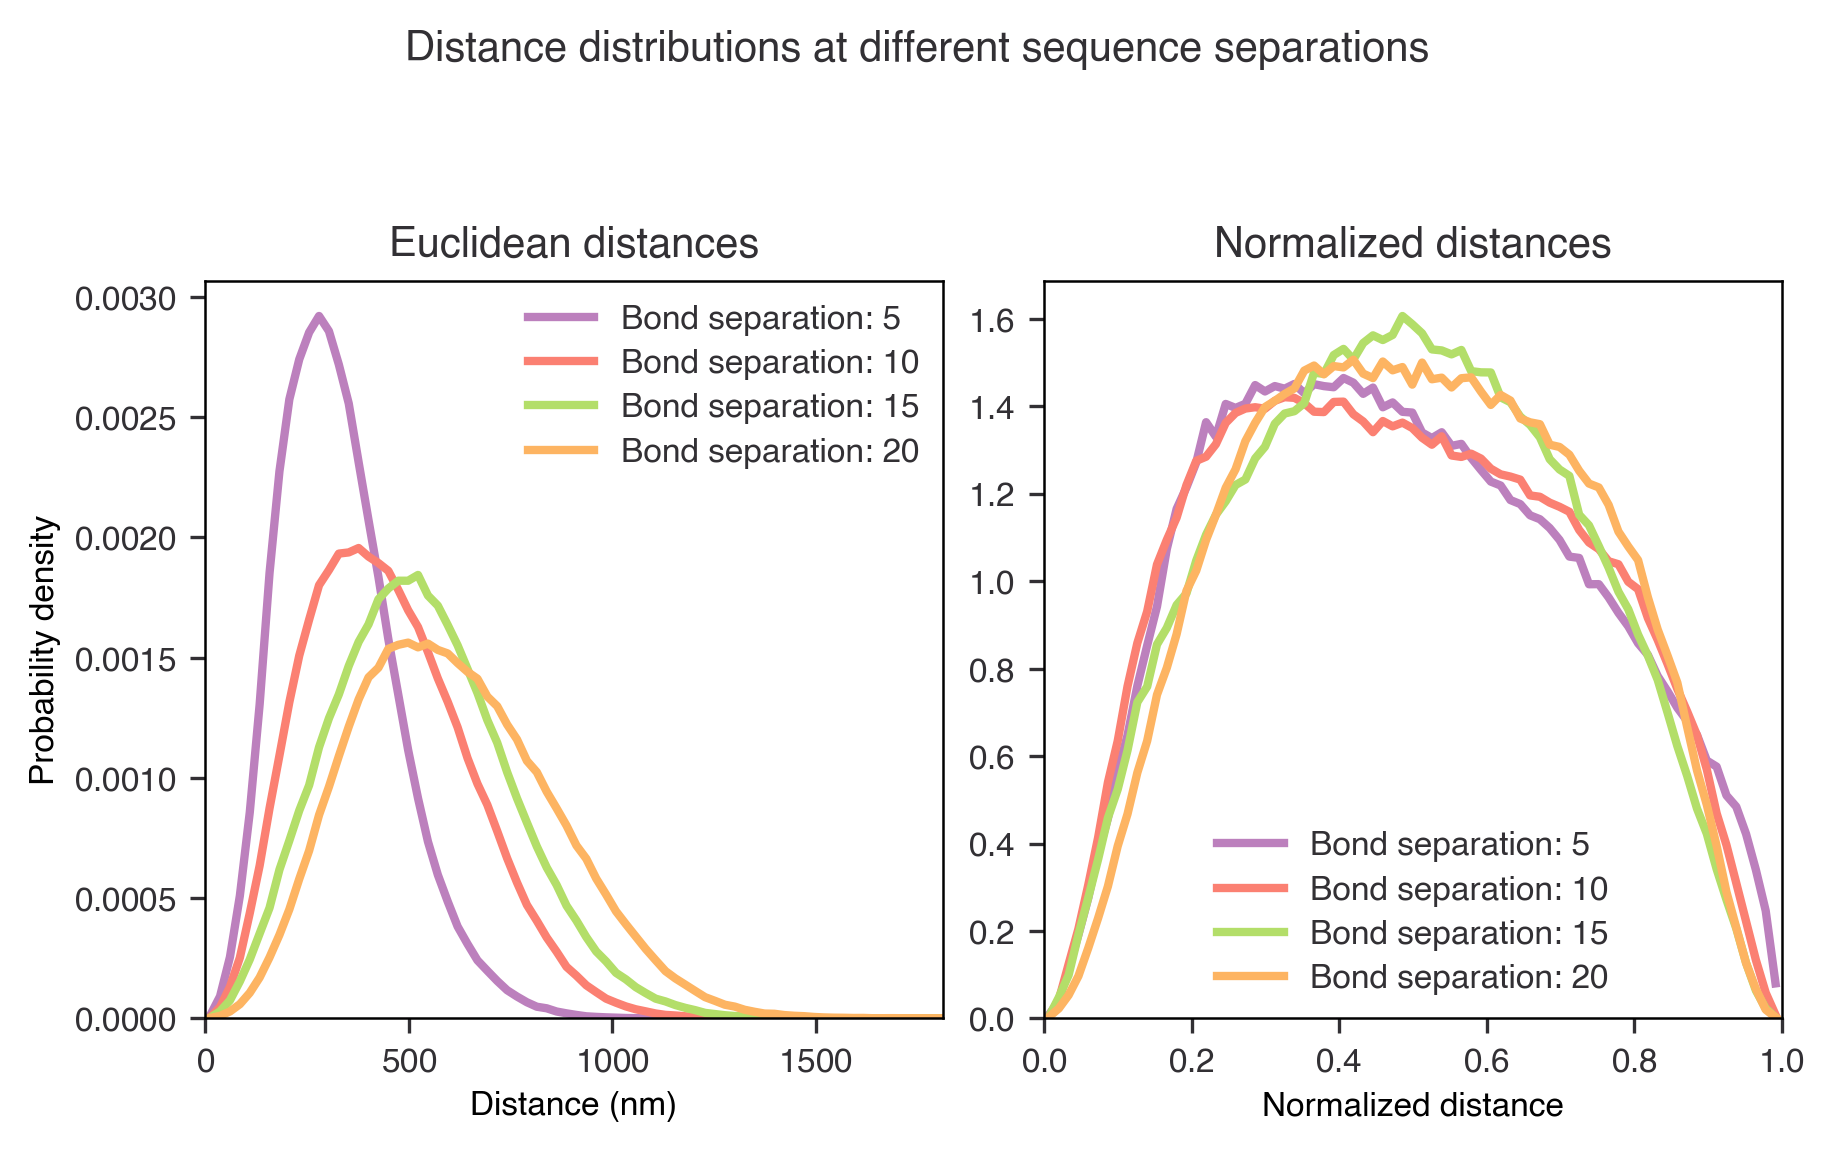

In [13]:
conformations = coords.distances
norm_conformations = conformations.normalize()
conformations._values*= 100 # to nm 
num_beads = conformations.num_beads

seps = [5,10,15,20] # Bond separations to show the distrubitions for

nbins = 75

################################################
# Make plots

fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(6,4),layout='constrained')

for i in range(2):
    if i == 1:
        del conformations
        conformations = norm_conformations
    ax = axes[i]
    data = []
    for sep in seps:
        data.append(conformations.values[...,range(num_beads-sep),range(sep,num_beads)].flatten())

    maxx = max([d.max() for d in data])
    bins = torch.arange(0,maxx*(1+.5/nbins),maxx/nbins)
    x = ((bins[:-1] + bins[1:])/2).numpy()
    maxx = 0 
    for k,sep in enumerate(seps):
        y = torch.histogram(data[k],bins=bins,density=True).hist.numpy()
        maxx = max(maxx, y.max())
        ax.plot(x,y,label=f'Bond separation: {sep}')

    xlims = [0,max(x[-1],1)]
    ylims = [0,maxx * 1.05]
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_aspect( (xlims[1]-xlims[0])/(ylims[1]-ylims[0]) )

    '''
    data = [ torch.histogram(d,bins=bins).hist for d in data ]


    
        ax.hist(conformations.values[...,range(num_beads-sep),range(sep,num_beads)].flatten().numpy(),density=True,label=f'Bond separation: {sep}',bins=bins,alpha=.4)
    '''
    #ax.set_title('Normalized distances distribution: Gaussian chain')
    #ax.set_title('Normalized distances distribution: Chromosome conformations')
    if i == 0:
        ax.set_title('Euclidean distances')
        ax.set_ylabel('Probability density')
        ax.set_xlabel('Distance (nm)')
    else:
        ax.set_title('Normalized distances')
        ax.set_xlabel('Normalized distance')
        
    ax.legend(framealpha=0)
fig.suptitle('Distance distributions at different sequence separations')
del norm_conformations 

fig.savefig(save_folder + 'normalization.pdf')